## finetuning for longformer model

*##* Transformers is all you need

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


## Importing dependencies

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
# sns.set_style("whitegrid")
# sns.despine()
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Loading Data and splitting it to train and test

In [4]:
from datasets import load_dataset

bbc_news = load_dataset("gopalkalpande/bbc-news-summary")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/gopalkalpande--bbc-news-summary-2a01b492fd0ba579/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
bbc_news = bbc_news['train'].train_test_split(test_size=0.2,shuffle=True)
bbc_news

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 445
    })
})

## visualizing data

In [6]:
bbc_news['train'][0]

{'File_path': 'entertainment',
 'Articles': "Boogeyman takes box office lead..The low-budget horror film Boogeyman has knocked Robert de Niro thriller Hide and Seek from the top spot at the UK box office...The film, in which a young man is forced to revisit a traumatic childhood experience, took £788,439 in its first three days on release. Hide And Seek, which was knocked off the top of the US box office by Boogeyman last month, fell one place. Oscar nominee Hotel Rwanda was also a new entry in the chart, at number five. The film, which scored Oscar nominations for Don Cheadle and British actress Sophie Okonedo, made £507, 596 in its first week of nationwide release...Comedy sequel Meet The Fockers and Shall We Dance?, starring Jennifer Lopez and Richard Gere, completed the top five. Clint Eastwood's Million Dollar Baby re-entered the charts at number eight, following its recent success at the Oscars. The boxing drama, which won four awards including best film and best director, has ma

<Axes: ylabel='count'>

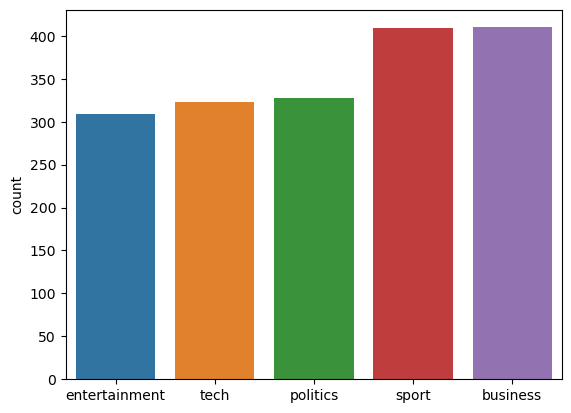

In [7]:
category_train = bbc_news['train']['File_path']
sns.countplot(x=category_train)

<Axes: ylabel='count'>

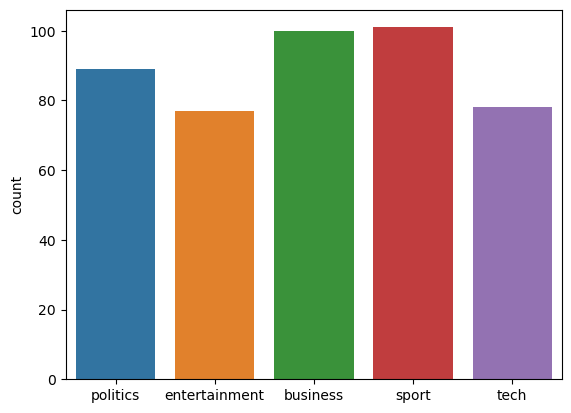

In [8]:
category_test = bbc_news['test']['File_path']
sns.countplot(x=category_test)

In [9]:
bbc_news.set_format(type='pandas')
df_train = bbc_news['train'][:]
df_test = bbc_news['test'][:]

## Preprocessing dataset

In [10]:
import re
import nltk
nltk.download('punkt')
!pip install contractions
import contractions
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.tokenize import sent_tokenize
from datasets import Dataset,DatasetDict
def remove_stopwords(text):
    words = text.split()
#     lemmatizer = WordNetLemmatizer()
    processed_text = [word for word in words if word not in stopwords.words('english')]
#     print(processed_text)
#     processed_text = [ lemmatizer.lemmatize(word) for word in processed_text]
#     print(processed_text)
    return ' '.join(processed_text)
def pre_process_df(df1):
    df = df1.copy()
    prefix = "summarize: "
    for col in ['Articles']:
        df[col] = df[col].apply(lambda x: contractions.fix(x))
        df[col] = df[col].apply(str.lower)
        df[col] = df[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
        df[col] = df[col].apply(lambda x: remove_stopwords(x))
        df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
        df[col] = df[col].apply(lambda x: prefix+x)
    return df
def text_len(df1):
    df = df1.copy()
    text_len = []
    for text in df['Articles']:
        tweet_len = len(text.split())
        text_len.append(tweet_len)
    df['text_len'] = text_len
    return df  
bbc_news_train = text_len(pre_process_df(df_train))
bbc_news_test = text_len(pre_process_df(df_test))
ds_dict = {'train' : Dataset.from_pandas(bbc_news_train),
           'test' : Dataset.from_pandas(bbc_news_test)}
bbc_news = DatasetDict(ds_dict)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.4 MB/s eta 0:00:00


In [11]:
bbc_news['train'][10]

{'File_path': 'tech',
 'Articles': 'summarize: gizmondo gadget hits shelves gizmondo combined media player phone gaming gadget goes sale saturday priced £229 handheld device debuting uk goes sale us mainland europe next weeks catalogue 20 games prepared gadget including great escape conflict vietnam british backed gadget faces stiff competition handheld gaming devices made nintendo sony gizmondo device packs lot functions inside black cover aimed gamers want game playing gadgets used play games music tracks movies take store digital photos used like mobile phone send text multimedia e mail messages phone service enable people send messages provided pre pay vodafone accounts bundled device also works gps global position system also used navigation aid support variety location based services gprs bluetooth wireless data systems onboard mean used multi player gaming gadget available gizmondo store london regent street several retail partners although device rolls together impressive list 

## Converting dataset to format required by our model

In [12]:
from transformers import AutoTokenizer
model_checkpoint = "allenai/led-base-16384"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# sequence = "Using a Transformer network is simple"
# text = tokenizer.tokenize(bbc_news['train'][10]['Articles'])
max_input_length = 2048
max_target_length = 200
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["Articles"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["Summaries"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
# def tokenize_function(example):
#     return tokenizer(example["Articles"], example["Summaries"], truncation=True)
tokenized_datasets = bbc_news.map(preprocess_function, batched=True)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries', 'text_len', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries', 'text_len', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 445
    })
})

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(bbc_news['train'].column_names)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 445
    })
})

## Importing pretrained model

In [14]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

## Args for finetuning model for our bbc dataset

In [15]:
from transformers import Seq2SeqTrainingArguments

batch_size = 1
num_train_epochs = 4
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-bbc-lemmatized",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
#     push_to_hub = True
)

## metric for evaluation

In [16]:
import numpy as np
!pip install rouge_score
!pip install evaluate
import evaluate
rouge_score = evaluate.load("rouge")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
#     print(result)
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=dd48c2d6397a0a60f8cccf172ad3319adf5d59821009874353cb2221499139e5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━

In [17]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

## Finetuning our model

In [18]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LEDTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.348700,1.030782,16.448300,10.066300,14.544300,14.854000
2,0.752800,0.941072,16.708900,10.565400,14.825400,15.242100
3,0.473300,0.943081,17.802700,12.118300,16.095900,16.462800
4,0.308300,0.975643,17.436300,11.950100,15.782600,16.062500


TrainOutput(global_step=7116, training_loss=0.7207969592621382, metrics={'train_runtime': 2214.0145, 'train_samples_per_second': 3.214, 'train_steps_per_second': 3.214, 'total_flos': 1316737484034048.0, 'train_loss': 0.7207969592621382, 'epoch': 4.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.9756429195404053,
 'eval_rouge1': 17.4363,
 'eval_rouge2': 11.9501,
 'eval_rougeL': 15.7826,
 'eval_rougeLsum': 16.0625,
 'eval_runtime': 99.5893,
 'eval_samples_per_second': 4.468,
 'eval_steps_per_second': 4.468,
 'epoch': 4.0}

## Using saved checkpoint to see how our model works!!!

In [22]:
from transformers import pipeline

hub_model_id = "/kaggle/working/led-base-16384-finetuned-bbc-lemmatized/checkpoint-6500"
summarizer = pipeline("summarization", model=hub_model_id)
gen_kwargs = {"length_penalty":0.8 ,"max_length" :150 , "min_length" : 60 }

In [23]:
bbc_news["test"][0]["Articles"]

'summarize: labour seeks quell feud talk labour leadership put show unity campaign poster launch mps criticised tony blair gordon brown reports rift mr brown joined launch john prescott alan milburn man controversially put charge election planning mr blair private meeting monday saw normally loyal mps warn feuding could jeopardise election hopes follows new book charting disputes prime minister chancellor event first time mr milburn shared platform chancellor since taking mr brown traditional poll planning role pair chatted amicably mr brown insisted happy current campaign task asked would deal claims trust prime minister mr brown replied see record economy british people trusting us run economy refused comment new book saying nobody distracted business government mr brown later told reporters course trust prime minister downing street cited comment reporters suggested mr brown pointedly failed deny claims told mr blair nothing could ever say could ever believe labour new posters say b

In [26]:
def print_summary(idx):
    review = bbc_news["test"][idx]["Articles"]
#     print(idx)
#     title = bbc_news["test"][idx]["File_Path"]
    summary = summarizer(bbc_news["test"][idx]["Articles"],**gen_kwargs)[0]["summary_text"]
    print(f"'>>> Review: {review}'")
# #     print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [27]:
print_summary(0)

'>>> Review: summarize: labour seeks quell feud talk labour leadership put show unity campaign poster launch mps criticised tony blair gordon brown reports rift mr brown joined launch john prescott alan milburn man controversially put charge election planning mr blair private meeting monday saw normally loyal mps warn feuding could jeopardise election hopes follows new book charting disputes prime minister chancellor event first time mr milburn shared platform chancellor since taking mr brown traditional poll planning role pair chatted amicably mr brown insisted happy current campaign task asked would deal claims trust prime minister mr brown replied see record economy british people trusting us run economy refused comment new book saying nobody distracted business government mr brown later told reporters course trust prime minister downing street cited comment reporters suggested mr brown pointedly failed deny claims told mr blair nothing could ever say could ever believe labour new p